# Exercise 4
Here I am using SOAP from the Davies corpora as I have tried but failed to locate minutes of the UNFCCC meetings. (Or else it will be very interesting to explore the social network of delegates from each country in the UNFCCC negotiations.) 

In [29]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn as sns#Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

In [3]:
corpora_address = "SOAP"
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [4]:
import zipfile

zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)
            
import pandas as pd

soap_dict = {}

for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [7]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1
    
#Extract Young and Restless from the main dataframe
amc = soap_df['Tokenized Texts'][0]


All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [9]:
#Now investigate how many characters exists in this opera
characters = {}

for token in amc:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1
print(len(characters))

810


In [10]:
#Now extract the main characters
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

David 2723
Tad 3548
Adam 2382
Ryan 4162
J.R. 3262
Greenlee 4599
Bianca 2169
Erica 3980
Jack 2334
Kendall 5289
Babe 2390
Krystal 2086
Zach 2424


In [11]:
#Here present the basic graph for characters in this opera.
actor_network = nx.Graph()

for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

actor_network.nodes.data()

NodeDataView({'David': {'lines_spoken': 2723, 'words': []}, 'Tad': {'lines_spoken': 3548, 'words': []}, 'Adam': {'lines_spoken': 2382, 'words': []}, 'Ryan': {'lines_spoken': 4162, 'words': []}, 'J.R.': {'lines_spoken': 3262, 'words': []}, 'Greenlee': {'lines_spoken': 4599, 'words': []}, 'Bianca': {'lines_spoken': 2169, 'words': []}, 'Erica': {'lines_spoken': 3980, 'words': []}, 'Jack': {'lines_spoken': 2334, 'words': []}, 'Kendall': {'lines_spoken': 5289, 'words': []}, 'Babe': {'lines_spoken': 2390, 'words': []}, 'Krystal': {'lines_spoken': 2086, 'words': []}, 'Zach': {'lines_spoken': 2424, 'words': []}})

In [15]:
#Create the graph
i = 0

for token in amc:
    i += 1
    if i > len(amc):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in amc[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(amc[i:j])

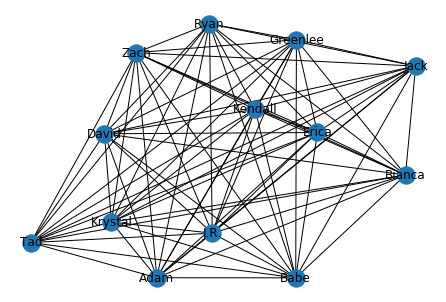

In [16]:
nx.draw(actor_network, with_labels=True)

In [17]:

#And if there are any structure between these people...
smaller_actor_network = nx.Graph()

for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])

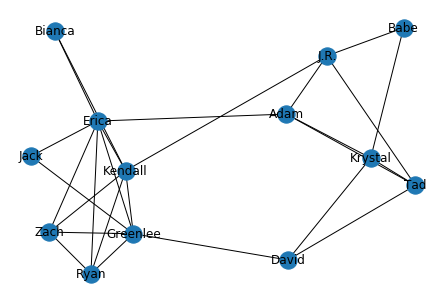

In [18]:
nx.draw(smaller_actor_network, with_labels=True)

In [19]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [20]:
c

[frozenset({'Adam',
            'Babe',
            'Bianca',
            'David',
            'Erica',
            'Greenlee',
            'J.R.',
            'Jack',
            'Kendall',
            'Krystal',
            'Ryan',
            'Tad',
            'Zach'})]

In [21]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [24]:
for actor, cen in dcentralities.items():
    print(actor, ':', cen)

David : 0.25
Tad : 0.3333333333333333
Greenlee : 0.5
Krystal : 0.3333333333333333
Adam : 0.3333333333333333
J.R. : 0.3333333333333333
Erica : 0.5833333333333333
Ryan : 0.3333333333333333
Kendall : 0.5
Zach : 0.3333333333333333
Babe : 0.16666666666666666
Jack : 0.16666666666666666
Bianca : 0.16666666666666666


In [25]:
import nltk
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [26]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud_2020.normalizeTokens(character_words))

In [27]:
L =[]
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

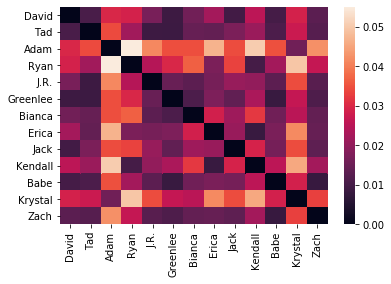

In [30]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

### Note:
In the smaller network above we see obvious clustering between the characters. The clusters are formed based on the the couple who got divorced in the show, Adam and Erica. 
